# 1.Import Data
## 1.1.Import Prediction

In [166]:
# import libraries
import pickle
import tensorflow as tf
import pandas as pd
import re
from tqdm import tqdm
import numpy as np

In [167]:
path_dict0={
    "CNN_preds":"CNN_preds",
    "Kernel_SVM_preds":"Kernel_SVM_preds",
    "SVM_preds":"SVM_preds",
    "LSTM_preds":"LSTM_preds",
    "GRU_preds":"GRU_preds"
}

path_dict1={
    "CNN_scores":"CNN_scores",
    "Kernel_SVM_scores":"Kernel_SVM_scores",
    "SVM_scores":"SVM_scores",
    "LSTM_scores":"LSTM_scores",
    "GRU_scores":"GRU_scores"
}

In [168]:
def open_pkl(parent_path,file_name):
    all_data=dict()
    for each_key in file_name.keys():
        name = file_name[each_key]
        pickle_file = open(parent_path+name+".pkl",mode="rb")
        data = pickle.load(pickle_file)
        pickle_file.close()
        all_data[each_key]=data
    return all_data

In [169]:
parent_path = "Prediction\\"
all_preds=open_pkl(parent_path,path_dict0)
all_scores=open_pkl(parent_path,path_dict1)

## 1.2.Import y_test

In [170]:
y_name={
    "y_test":"test_y",
    "y_train":"train_y"
}

In [171]:
parent_path="DataSet\\"
y_data = open_pkl(parent_path,y_name)
y_test = y_data["y_test"]

In [172]:
# in order to plot ROC curve and calculate AUC, I need to turn y label into 1 hot representation.
# transfer y label from {class:[0,1,2,3]} into {class: [1,0,0,0], [0,1,0,0],[0,0,1,0],[0,0,0,1]}
emotion = {"others":0,"happy":1,"sad":2,"angry":3}
y_test1hot = tf.keras.utils.to_categorical(y_test,num_classes=4)

## 1.3.Calculation on label

In [173]:
# function for calculate the number of each class in label
def calculate_class_no(y):
    emotion = {
        0:"others",
        1:"happy",
        2:"sad",
        3:"angry"
        }
    
    cal_y=dict()
    cal_y["others"]=0
    cal_y["happy"]=0
    cal_y["sad"]=0
    cal_y["angry"]=0
    length = len(y)
    for i in range(length):
        if y[i] == 0:
            cal_y["others"] +=1
        elif y[i] == 1:
            cal_y["happy"] +=1
        elif y[i] ==2:
            cal_y["sad"] +=1
        elif y[i] ==3:
            cal_y["angry"]+=1
    
    return cal_y

In [174]:
# function for crawl the dict and caculate the number of each class on label
def calculate_class_no_all(y_data):
    y_cal = dict()
    for key in y_data.keys():
        y_cal_one = calculate_class_no(y_data[key])
        y_cal[key]=y_cal_one
    
    return y_cal

In [175]:
# function for forming dataframe
def form_df_y(y_cal):
    new_dict = dict()
    columns = ["data version","others","happy","sad","angry"]
    for each in columns:
        new_dict[each]=list()
    
    for each_key in y_cal.keys():
        new_dict["data version"].append(each_key)
        for each_data in y_cal[each_key].keys():
            new_dict[each_data].append(y_cal[each_key][each_data])
    df = pd.DataFrame.from_dict(new_dict)
    
    return df

In [176]:
y_cal = calculate_class_no_all(y_data)

In [177]:
y_cal

{'y_test': {'others': 4677, 'happy': 284, 'sad': 250, 'angry': 298},
 'y_train': {'others': 14948, 'happy': 4243, 'sad': 5463, 'angry': 5506}}

In [178]:
df_y = form_df_y(y_cal)

# save dataframe as excel for further comparison picture extraction
save_path="Prediction\\df_y"
df_y.to_excel(save_path+".xlsx",sheet_name="comparison_evaluation")

In [179]:
df_y

,data version,others,happy,sad,angry
0,y_test,4677,284,250,298
1,y_train,14948,4243,5463,5506


# 2.Evaluation on accuracy, precision, recall, F1 score

In [180]:
# function for getting accuracy, precision, recall, F1 score on each label
def calculate_eachlabel(y_test,y_pred,choose):
    emotion={
        "others":0,
        "happy":1,
        "sad":2,
        "angry":3
        }
    label_choose = emotion[choose]
    
    TP =0
    TN =0
    FP =0
    FN =0
    
    for i in range(len(y_test)):
        if y_test[i] == label_choose and y_pred[i] == label_choose:
            TP +=1
            
        elif y_test[i] == label_choose and y_pred[i] != label_choose:
            FN +=1
        
        elif y_test[i] != label_choose and y_pred[i] == label_choose:
            FP +=1
        elif y_test[i] != label_choose and y_pred[i] != label_choose:
            TN +=1
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1_score = 2*(precision*recall)/(precision + recall)
    
    return accuracy,precision,recall,f1_score

In [181]:
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# print evaluation result
def get_evaluation(y_test,y_pred):
    emotion = ["others","happy","sad","angry"]
    ev = dict()
    #ev["confusion_matrix"]=confusion_matrix(y_test,y_pred)
    ev["accuracy"] = accuracy_score(y_test,y_pred)
    ev["precision_macro"]=precision_score(y_test,y_pred,average="macro")
    ev["precision_micro"]=precision_score(y_test,y_pred,average="micro")
    ev["precision_weighted"]=precision_score(y_test,y_pred,average="weighted")
    ev["recall_macro"]=recall_score(y_test,y_pred,average="macro")
    ev["recall_micro"]=recall_score(y_test,y_pred,average="micro")
    ev["recall_weighted"]=recall_score(y_test,y_pred,average="weighted")
    ev["F1_score_macro"]=f1_score(y_test,y_pred,average="macro")
    ev["F1_score_micro"]=f1_score(y_test,y_pred,average="micro")
    ev["F1_score_weighted"]=f1_score(y_test,y_pred,average="weighted")
    for each in emotion:
        accu_each = "accuracy_{0}".format(each)
        pre_each = "precision_{0}".format(each)
        re_each ="recall_{0}".format(each)
        f1_each = "F1_score_{0}".format(each)
        ev[accu_each],ev[pre_each],ev[re_each],ev[f1_each]=calculate_eachlabel(y_test,y_pred,each)

    return ev

In [182]:
def process_preds(y_test,all_preds,method):
    all_results=dict()
    for each_model in all_preds.keys():
        alldata_results=dict()
        for each_data in all_preds[each_model].keys():
            result = eval(method)(y_test,all_preds[each_model][each_data])
            alldata_results[each_data]=result
        all_results[each_model]=alldata_results
    
    return all_results

In [183]:
all_ev = process_preds(y_test,all_preds,"get_evaluation")

In [184]:
# form dataframe from evaluation dict
def form_df(all_evaluation):
    
    columns=["model","data version","accuracy","precision_macro",
             "recall_macro","F1_score_macro","precision_micro","recall_micro",
             "F1_score_micro","precision_weighted","recall_weighted",
             "F1_score_weighted"]
    
    emotion = emotion = ["others","happy","sad","angry"]
    for each in emotion:
        accu_each = "accuracy_{0}".format(each)
        pre_each = "precision_{0}".format(each)
        re_each ="recall_{0}".format(each)
        f1_each = "F1_score_{0}".format(each)
        columns.append(accu_each)
        columns.append(pre_each)
        columns.append(re_each)
        columns.append(f1_each)
    
    new_dict = dict()
    
    for each_column in columns:
        new_dict[each_column]=list()
    
    for each_model in all_evaluation.keys():
        for each_data in all_evaluation[each_model].keys():                    
            new_dict["model"].append(re.sub(r'\_preds','',each_model))
            new_dict["data version"].append(each_data)
            
            for each_column in all_evaluation[each_model][each_data].keys():
                new_dict[each_column].append(all_evaluation[each_model][each_data][each_column])
            
    
    df=pd.DataFrame.from_dict(new_dict)
    
    return df

In [185]:
df=form_df(all_ev)
# save dataframe as excel for further comparison picture extraction
save_path="Prediction\\df_evaluation"
df.to_excel(save_path+".xlsx",sheet_name="comparison_evaluation")

In [186]:
df

,model,data version,accuracy,precision_macro,recall_macro,F1_score_macro,precision_micro,recall_micro,F1_score_micro,precision_weighted,...,recall_happy,F1_score_happy,accuracy_sad,precision_sad,recall_sad,F1_score_sad,accuracy_angry,precision_angry,recall_angry,F1_score_angry
0,CNN,test2,0.866037,0.634014,0.815111,0.702945,0.866037,0.866037,0.866037,0.900604,...,0.707746,0.580925,0.961154,0.546392,0.848,0.664577,0.950808,0.529032,0.825503,0.644823
1,CNN,test5,0.871665,0.647829,0.799548,0.707455,0.871665,0.871665,0.871665,0.900029,...,0.704225,0.613497,0.965148,0.585799,0.792,0.673469,0.945544,0.497942,0.812081,0.617347
2,Kernel_SVM,test0,0.830096,0.545535,0.634958,0.580876,0.830096,0.830096,0.830096,0.853764,...,0.404930,0.396552,0.940824,0.394444,0.568,0.465574,0.940824,0.468037,0.687919,0.557065
3,Kernel_SVM,test1,0.831911,0.551800,0.637733,0.586064,0.831911,0.831911,0.831911,0.854114,...,0.422535,0.415225,0.941732,0.398860,0.560,0.465890,0.941187,0.470183,0.687919,0.558583
4,Kernel_SVM,test2,0.837539,0.570301,0.690178,0.617386,0.837539,0.837539,0.837539,0.867819,...,0.538732,0.485714,0.944636,0.428198,0.656,0.518167,0.940824,0.468182,0.691275,0.558266
5,Kernel_SVM,test3,0.831004,0.545472,0.620501,0.575870,0.831004,0.831004,0.831004,0.850612,...,0.397887,0.395797,0.939917,0.383954,0.536,0.447412,0.942458,0.477108,0.664430,0.555400
6,Kernel_SVM,test4,0.830278,0.542263,0.610556,0.569945,0.830278,0.830278,0.830278,0.848241,...,0.387324,0.390764,0.939735,0.378698,0.512,0.435374,0.941550,0.471154,0.657718,0.549020
7,Kernel_SVM,test5,0.832819,0.556605,0.654760,0.596264,0.832819,0.832819,0.832819,0.858985,...,0.496479,0.457792,0.941006,0.397820,0.584,0.473258,0.941187,0.469048,0.661074,0.548747
8,SVM,test0,0.818479,0.524840,0.607726,0.557386,0.818479,0.818479,0.818479,0.843293,...,0.387324,0.380623,0.936286,0.361644,0.528,0.429268,0.936468,0.440367,0.644295,0.523161
9,SVM,test1,0.824106,0.533910,0.612327,0.564394,0.824106,0.824106,0.824106,0.847213,...,0.397887,0.400709,0.936468,0.361111,0.520,0.426230,0.937194,0.445205,0.654362,0.529891


# 3.Evaluation with ROC curve, AUC on same model

In [187]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [188]:
def compute_roc_auc(y_test1hot, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_class = 4
    
    # compute roc curve and auc based on each label
    for i in range(n_class):
        fpr[i],tpr[i],_ = roc_curve(y_test1hot[:,i],y_score[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    # compute roc curve and auc based on average type = "micro"
    fpr["micro"],tpr["micro"],_=roc_curve(y_test1hot.ravel(),y_score.ravel())
    roc_auc["micro"]=auc(fpr["micro"],tpr["micro"])
    
    # compute roc curve and auc based on average type = "macro"
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_class):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
    # Finally average it and compute AUC
    mean_tpr = mean_tpr/n_class
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"],tpr["macro"])
    
    return fpr, tpr, roc_auc

In [189]:
def compute_roc_auc_singlemodel(y_test1hot, y_scores):
    fprs=dict()
    tprs=dict()
    roc_aucs=dict()
    for key in tqdm(y_scores.keys()):
        fprs[key],tprs[key],roc_aucs[key]=compute_roc_auc(y_test1hot,y_scores[key])
    
    return fprs,tprs,roc_aucs

In [190]:
def compute_roc_auc_allmodel(y_test1hot, y_all_scores):
    all_fprs=dict()
    all_tprs=dict()
    all_roc_aucs=dict()
    for each_model in y_all_scores.keys():
        fprs,tprs,roc_aucs=compute_roc_auc_singlemodel(y_test1hot, y_all_scores[each_model])
        all_fprs[each_model]=fprs
        all_tprs[each_model]=tprs
        all_roc_aucs[each_model]=roc_aucs
        
    return all_fprs,all_tprs,all_roc_aucs

In [191]:
# compute fpr, tpr, roc_auc on each data under each model
all_fprs,all_tprs,all_roc_aucs = compute_roc_auc_allmodel(y_test1hot, all_scores)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 125.02it/s]


In [192]:
def draw_pic(fpr_range,tpr_range,roc_auc,data_version,choose,color):
    emotion_no={
            0:"others",
            1:"happy",
            2:"sad",
            3:"angry"
     }
    if choose != "micro" and choose !="macro":
        label_name = emotion_no[choose]
    else:
        label_name = choose
    
    plt.plot(fpr_range[choose],tpr_range[choose],color=color,lw=2,
             label="{0} ROC (AUC: {1:0.2f}) on data {2}".format(label_name,roc_auc[choose],data_version))

In [193]:
def draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type="both_embedding",choose="micro"):
    modelname_key = modelname +"_scores"
    fprs=all_fprs[modelname_key]
    tprs=all_tprs[modelname_key]
    roc_aucs=all_roc_aucs[modelname_key]
    
    
    emotion = {"others":0,"happy":1,"sad":2,"angry":3}
    
    # set colors choice
    colors = ["r","navy", "g","cornflowerblue","y","magenta"]
    
    # set the content of data version
    word2vec_list=["test0","test1","test2"]
    glove_list=["test3","test4","test5"]
    
    if modelname == "CNN" or modelname == "LSTM" or modelname == "GRU":
        word2vec_list=["test2"]
        glove_list=["test5"]
        
    both_list=word2vec_list+glove_list
    label_name = choose
    
    # set the label_name, i.e. choose to its number type if it's happy, sad, angry, others.
    if choose !="micro" and choose !="macro":
        choose = emotion[choose]
    
    
    
    
    
    plt.figure()
    
    # draw the line based on data resource type
    if data_type == "both_embedding":
        for pos in range(len(both_list)):
            data_version = both_list[pos]
            color = colors[pos]
            draw_pic(fprs[data_version],tprs[data_version],
                     roc_aucs[data_version],data_version,choose,color)
    elif data_type == "word2vec":
        for pos in range(len(word2vec_list)):
            data_version = both_list[pos]
            color = colors[pos]
            draw_pic(fprs[data_version],tprs[data_version],
                     roc_aucs[data_version],data_version,choose,color)
    elif data_type == "glove":
        for pos in range(len(glove_list)):
            data_version = both_list[pos]
            color = colors[pos]
            draw_pic(fprs[data_version],tprs[data_version],
                     roc_aucs[data_version],data_version,choose,color)
    
    
    
    plt.plot([0,1],[0,1],linestyle="--",color='k',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{0} ROC Curve by model {1}'.format(label_name,modelname))
    
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\{a}\\Comparison\\{b} ROC Curve by model {c} on data {d}.png".format(a=modelname,b=label_name,c=modelname,d=data_type))
    plt.show()
    
    

## 3.1. SVM

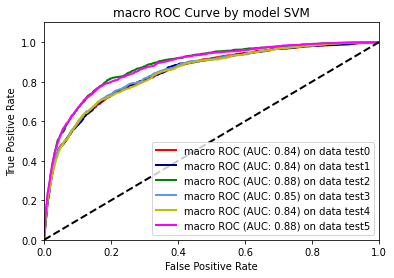

In [194]:
modelname="SVM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

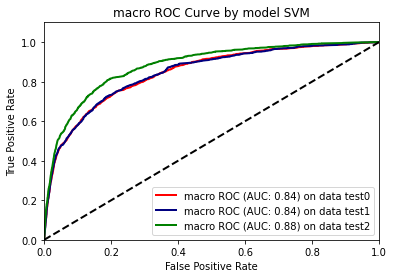

In [195]:
modelname="SVM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

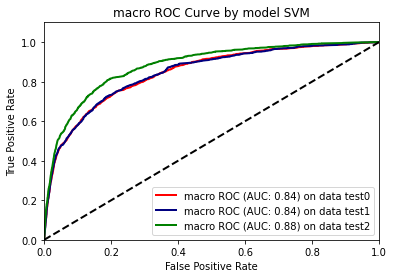

In [196]:
modelname="SVM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

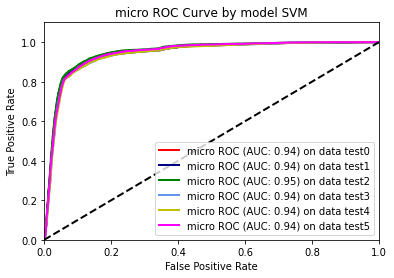

In [197]:
modelname="SVM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

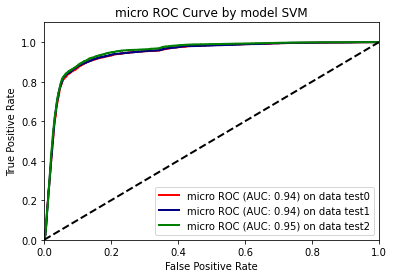

In [198]:
modelname="SVM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

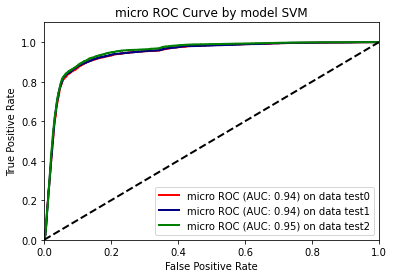

In [199]:
modelname="SVM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

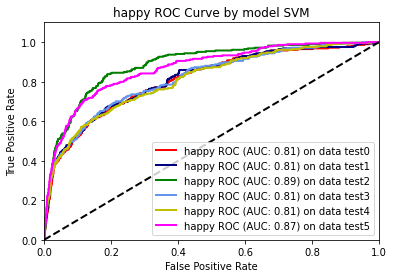

In [200]:
modelname="SVM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

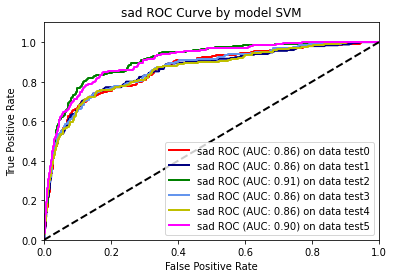

In [201]:
modelname="SVM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

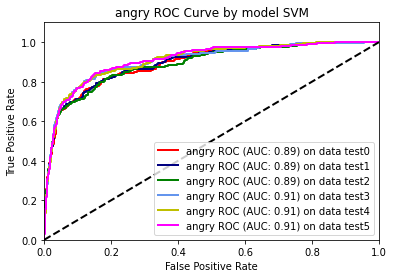

In [202]:
modelname="SVM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

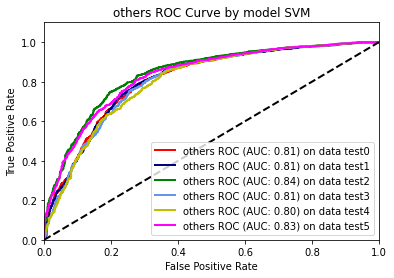

In [203]:
modelname="SVM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.2.Kernel SVM

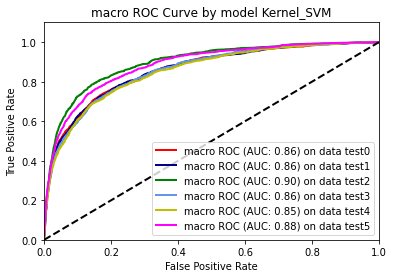

In [204]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

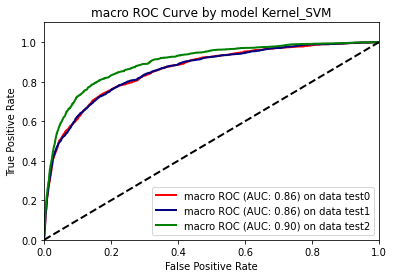

In [205]:
modelname="Kernel_SVM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

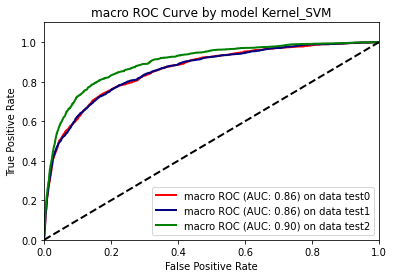

In [206]:
modelname="Kernel_SVM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

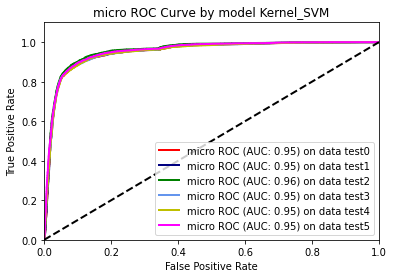

In [207]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

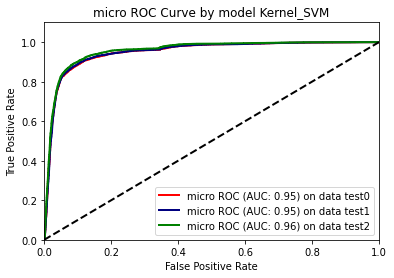

In [208]:
modelname="Kernel_SVM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

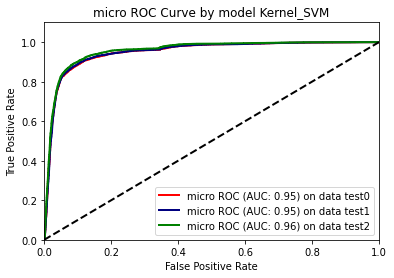

In [209]:
modelname="Kernel_SVM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

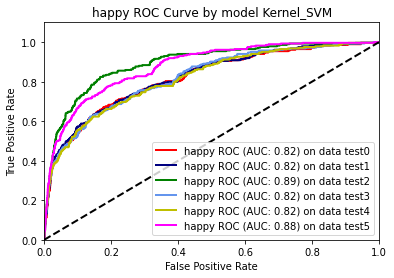

In [210]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

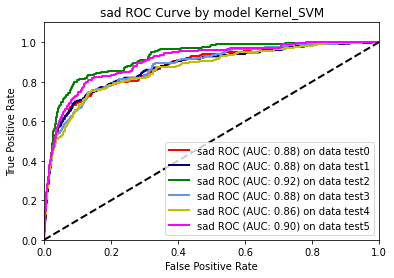

In [211]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

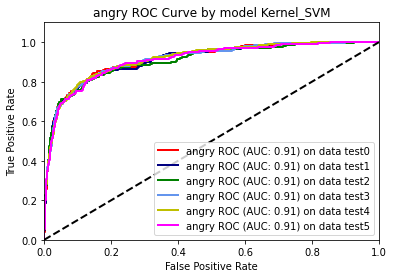

In [212]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

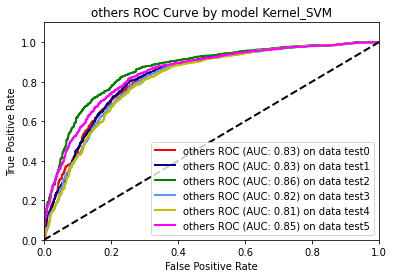

In [213]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.3.CNN

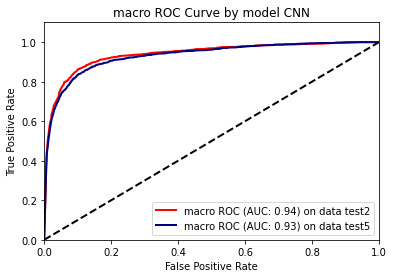

In [214]:
modelname="CNN"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

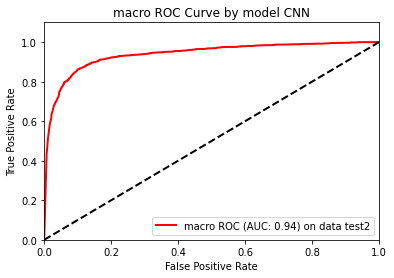

In [215]:
modelname="CNN"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

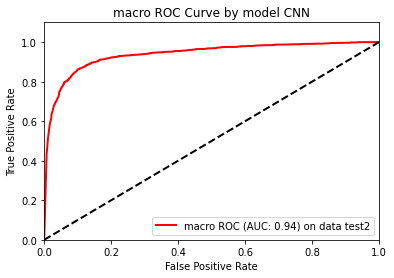

In [216]:
modelname="CNN"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

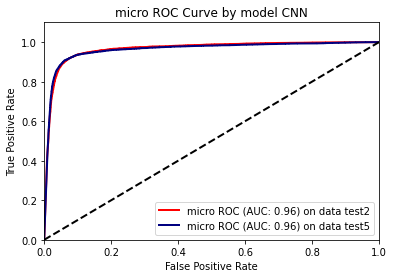

In [217]:
modelname="CNN"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

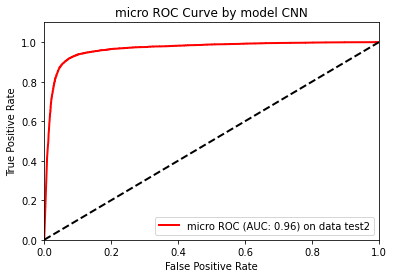

In [218]:
modelname="CNN"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

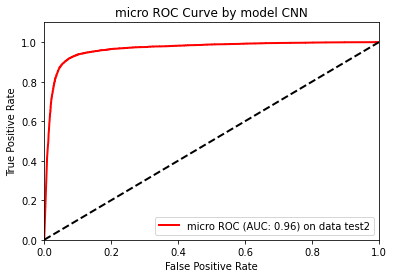

In [219]:
modelname="CNN"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

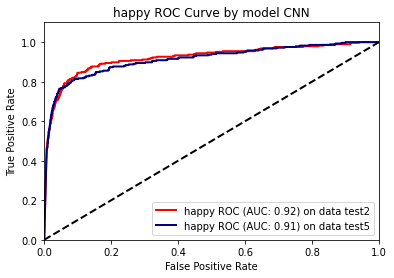

In [220]:
modelname="CNN"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

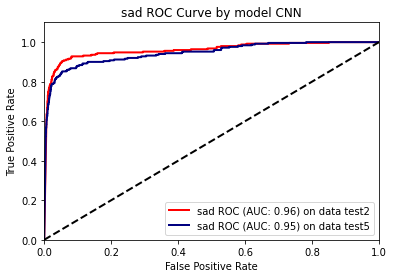

In [221]:
modelname="CNN"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

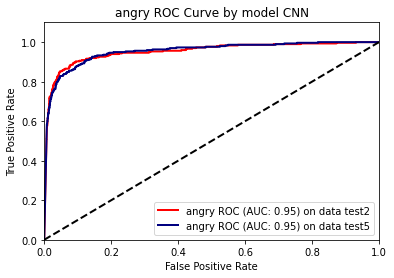

In [222]:
modelname="CNN"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

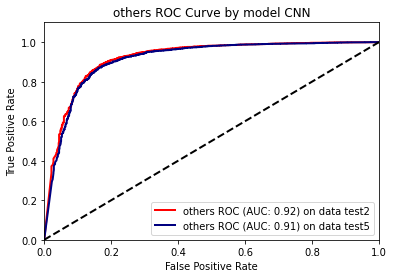

In [223]:
modelname="CNN"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.4.LSTM

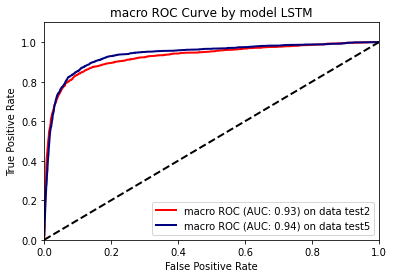

In [224]:
modelname="LSTM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

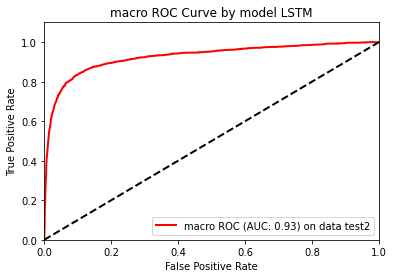

In [225]:
modelname="LSTM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

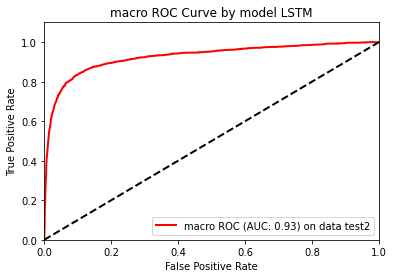

In [226]:
modelname="LSTM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

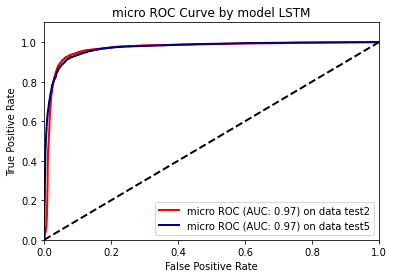

In [227]:
modelname="LSTM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

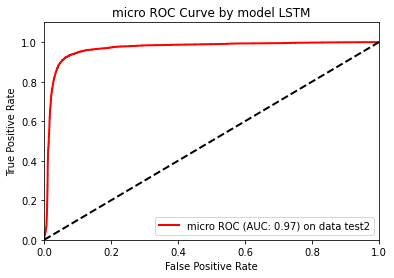

In [228]:
modelname="LSTM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

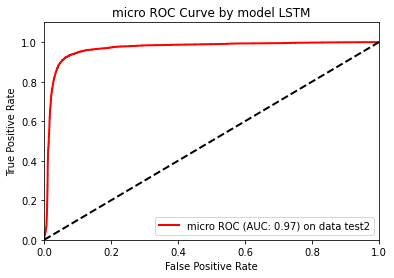

In [229]:
modelname="LSTM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

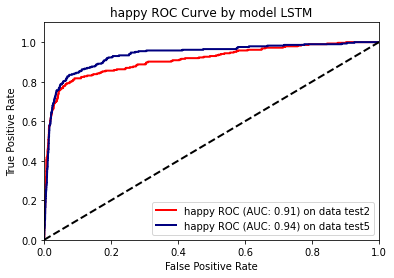

In [230]:
modelname="LSTM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

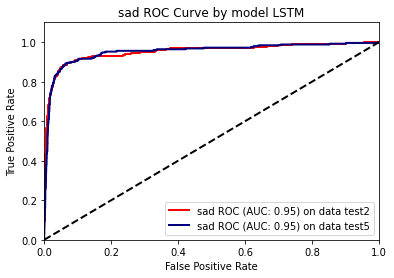

In [231]:
modelname="LSTM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

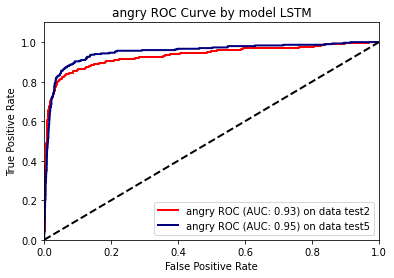

In [232]:
modelname="LSTM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

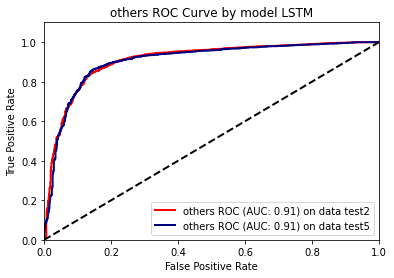

In [233]:
modelname="LSTM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.5.GRU

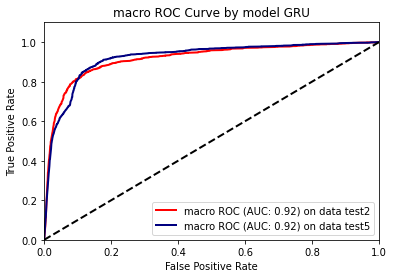

In [234]:
modelname="GRU"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

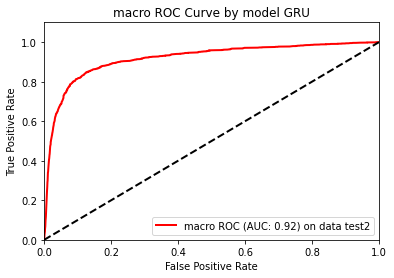

In [235]:
modelname="GRU"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

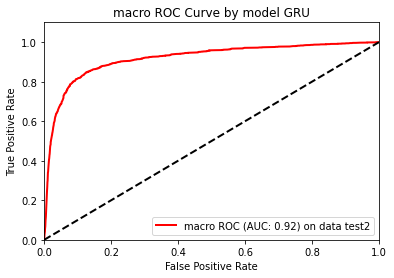

In [236]:
modelname="GRU"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

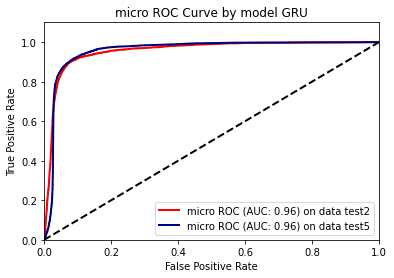

In [237]:
modelname="GRU"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

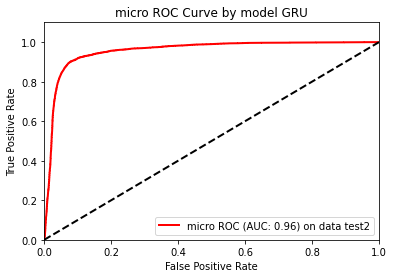

In [238]:
modelname="GRU"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

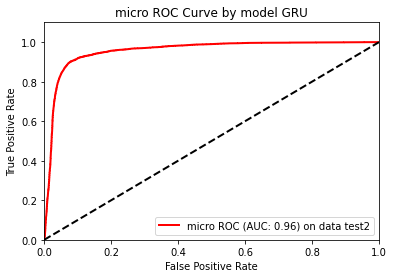

In [239]:
modelname="GRU"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

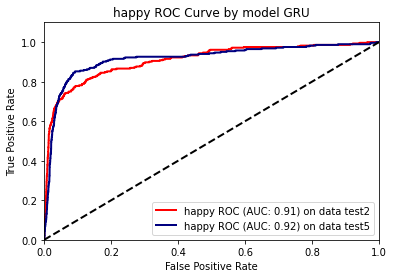

In [240]:
modelname="GRU"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

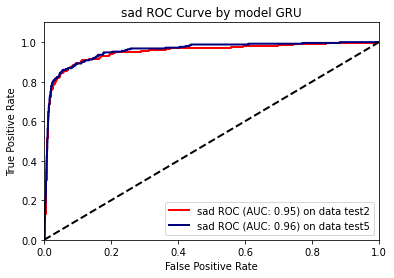

In [241]:
modelname="GRU"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

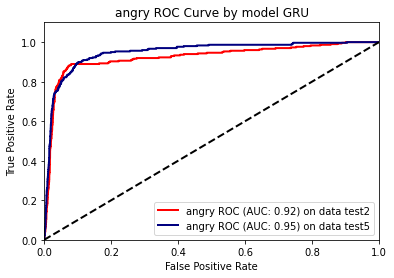

In [242]:
modelname="GRU"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

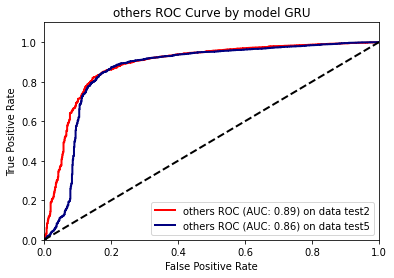

In [243]:
modelname="GRU"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

# 4.Evaluation with ROC, AUC on different model

In [244]:
def draw_pic_diff(fpr_range,tpr_range,roc_auc,modelname,choose,color):
    emotion_no={
            0:"others",
            1:"happy",
            2:"sad",
            3:"angry"
     }
    if choose != "micro" and choose !="macro":
        label_name = emotion_no[choose]
    else:
        label_name = choose
    
    plt.plot(fpr_range[choose],tpr_range[choose],color=color,lw=2,
             label="{0} ROC (AUC: {1:0.2f}) by {2}".format(label_name,roc_auc[choose],modelname))

In [245]:
def draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose="micro"):
    modelnames=list(all_fprs.keys())
    

    emotion = {"others":0,"happy":1,"sad":2,"angry":3}
    
    # set colors choice
    colors = ["r","navy", "g","cornflowerblue","y","magenta"]
    
    label_name = choose
    
    # set the label_name, i.e. choose to its number type if it's happy, sad, angry, others.
    if choose !="micro" and choose !="macro":
        choose = emotion[choose]
    
    
    plt.figure()
    
    # draw the line based on data resource type
    for pos in range(len(modelnames)):
        each_model = modelnames[pos]
        color = colors[pos]
        modelname = re.sub(r'\_scores','',each_model)
        draw_pic_diff(all_fprs[each_model][data_version],all_tprs[each_model][data_version],
             all_roc_aucs[each_model][data_version],modelname,choose,color)
    
    
    
    plt.plot([0,1],[0,1],linestyle="--",color='k',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{a} ROC Curve with all models on data {b}.png'.format(a=label_name,b=data_version))
    
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\{a} ROC Curve with all models on data {b}.png".format(a=label_name,b=data_version))
    plt.show()
    

## 4.1. test2
- data based on word2vec
- data with correction of misspell and translation of shorthand words and acronyms
- data with emoji/emoticon values inside

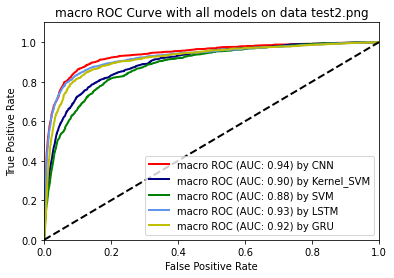

In [246]:
data_version="test2"
choose = "macro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

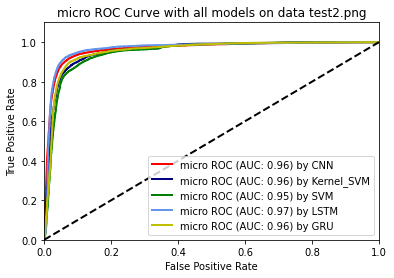

In [247]:
data_version="test2"
choose = "micro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

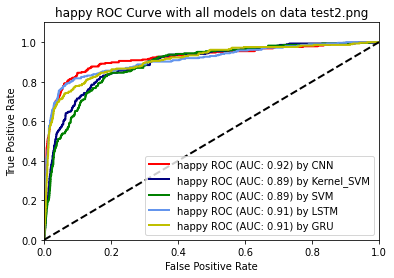

In [248]:
data_version="test2"
choose = "happy"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

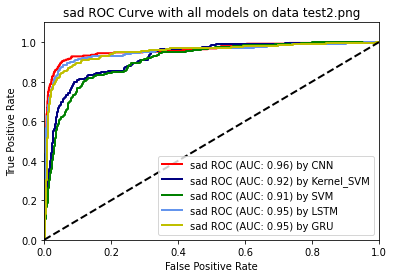

In [249]:
data_version="test2"
choose = "sad"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

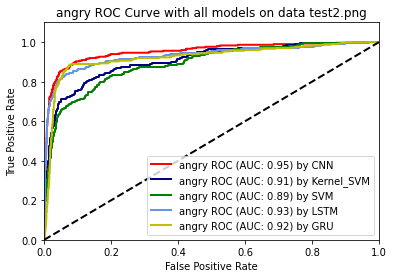

In [250]:
data_version="test2"
choose = "angry"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

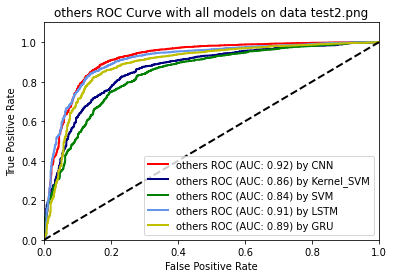

In [251]:
data_version="test2"
choose = "others"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

## 4.2. test5
- data based on glove
- data with correction of misspell and translation of shorthand words and acronyms
- data with emoji/emoticon values inside

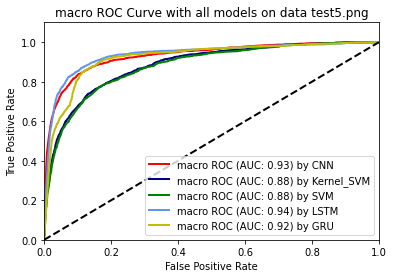

In [252]:
data_version="test5"
choose = "macro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

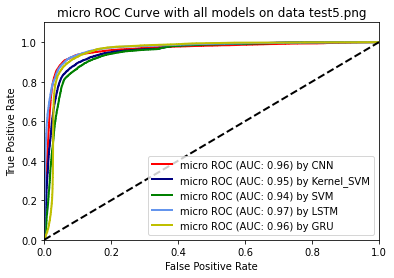

In [253]:
data_version="test5"
choose = "micro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

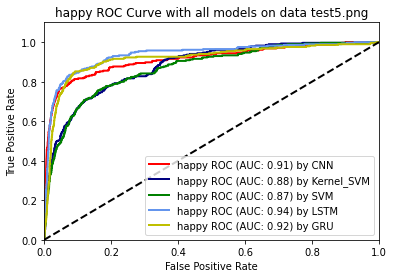

In [254]:
data_version="test5"
choose = "happy"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

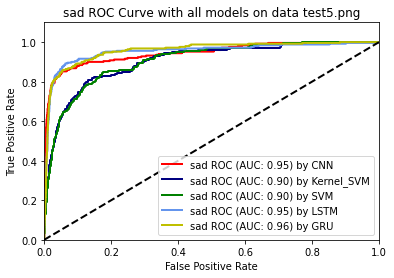

In [255]:
data_version="test5"
choose = "sad"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

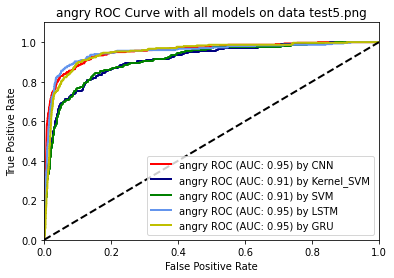

In [256]:
data_version="test5"
choose = "angry"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

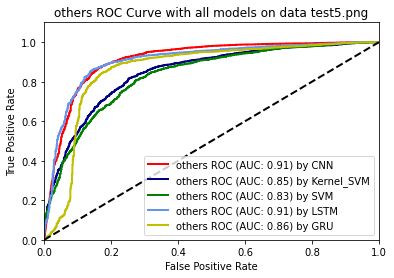

In [257]:
data_version="test5"
choose = "others"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)